In [1]:
# Import libraries
import datetime as dt
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from arch.bootstrap import StationaryBootstrap
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Read in stock prices using pandas datareader
start = ('1-01-2001')
end = ('12-31-2021')

df = web.DataReader("AAPL", 'yahoo', start, end)

In [3]:
# Calculate daily returns from Adj Close data
df['returns'] = df['Adj Close'].pct_change()
df = df.dropna()
df.head()

,High,Low,Open,Close,Volume,Adj Close,returns
Date,,,,,,,
2001-01-03,0.297991,0.257813,0.258929,0.292411,817073600.0,0.250384,0.100841
2001-01-04,0.330357,0.300223,0.323940,0.304688,739396000.0,0.260896,0.041986
2001-01-05,0.310268,0.286830,0.302455,0.292411,412356000.0,0.250384,-0.040294
2001-01-08,0.303292,0.284598,0.302455,0.295759,373699200.0,0.253251,0.011450
2001-01-09,0.315011,0.295759,0.300223,0.306920,588929600.0,0.262808,0.037737


In [4]:
# Calculate optimal block size for bootstrapping time series data
from arch.bootstrap import optimal_block_length

opt = optimal_block_length(df['returns'] ** 2) # per author we use the squared market return since the Sharpe ratio 
                                               # depends on the mean and the variance, and the autocorrelation in the squares 
                                               # is stronger than in the returns.
print(opt)

         stationary   circular
returns  137.922596  157.88196


In [5]:
# Define Sharpe Ratio function that also calculates annualized mean and std dev of returns 
def sharpe_ratio(x):
    mu, sigma = 252 * x.mean(), np.sqrt(252 * x.var())
    values = np.array([mu, sigma, mu / sigma]).squeeze()
    index = ["mu", "sigma", "SR"]
    return pd.Series(values, index=index)

In [7]:
# Bootstrap returns data based on optimal block length by applying 
# Stationary Bootstrap which uses blocks with exponentially distributed lengths
bs = StationaryBootstrap(138,df['returns'])

# Obtain Sharpe Ratio, mean returns and st dev for bootstrapped data
results = bs.apply(sharpe_ratio)

In [8]:
params = sharpe_ratio(df['returns'])
params

mu       0.383701
sigma    0.363099
SR       1.056740
dtype: float64

In [9]:
# Calculate confidence interval 0.95 for Sharpe Ratio
ci = bs.conf_int(sharpe_ratio, 1000, method="percentile", size=0.95)
ci = pd.DataFrame(ci, index=["Lower", "Upper"], columns=params.index)
print(ci)

             mu     sigma        SR
Lower  0.234503  0.313307  0.640979
Upper  0.544222  0.410997  1.526054


Text(0.5, 1.0, 'SR Confidence Interval 0.95')

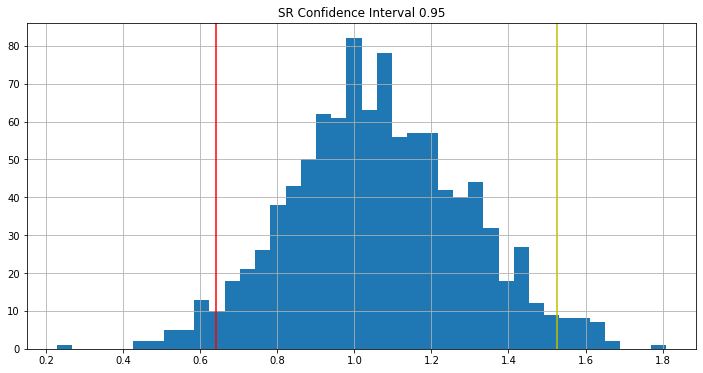

In [10]:
# Plot confidence interval 0.95 for Sharpe Ratio
sharpe = pd.DataFrame(results[:, -1:], columns=["SR"])
fig = sharpe.hist(bins=40, figsize=(12,6))
plt.axvline(ci.iloc[1,2], c='y')
plt.axvline(ci.iloc[0,2], c='r')
plt.title('SR Confidence Interval 0.95')